# Custom Indexes

While Xoak provides some built-in index adapters, it is easy to adapt and register new indexes. 

In [1]:
import numpy as np
import xarray as xr
import xoak

An instance of `xoak.IndexRegistry` by default contains a collection of Xoak built-in index adapters:

In [2]:
ireg = xoak.IndexRegistry()

ireg

<IndexRegistry (4 indexes)>
scipy_kdtree
sklearn_kdtree
sklearn_balltree
sklearn_geo_balltree

## Example: add a brute-force "index"

Every Xoak supported index is a subclass of `xoak.IndexAdapter` that must implement the `build` and `query` methods. The `IndexRegistry.register` decorator may be used to register a new index adpater.

Let's create and register a new adapter, which simply performs brute-force nearest-neighbor lookup by computing the pairwise distances between all index and query points and finding the minimum distance. 

In [3]:
from sklearn.metrics.pairwise import pairwise_distances_argmin_min


@ireg.register('brute_force')
class BruteForceIndex(xoak.IndexAdapter):
    """Brute-force nearest neighbor lookup."""
    
    def build(self, points):
        # there is no index to build here, just return the points
        return points
    
    def query(self, index, points):
        positions, distances = pairwise_distances_argmin_min(points, index)
        return distances, positions


This new index now appears in the registry:

In [4]:
ireg

<IndexRegistry (5 indexes)>
scipy_kdtree
sklearn_kdtree
sklearn_balltree
sklearn_geo_balltree
brute_force

Let's use this index in the basic example below:

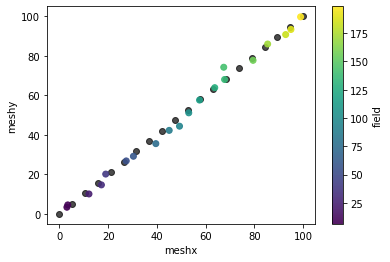

In [5]:
# create mesh
shape = (20, 20)
x = np.random.uniform(0, 100, size=shape)
y = np.random.uniform(0, 100, size=shape)

field = x + y

ds_mesh = xr.Dataset(
    coords={'meshx': (('x', 'y'), x), 'meshy': (('x', 'y'), y)},
    data_vars={'field': (('x', 'y'), field)},
)

# set the brute-force index (doesn't really build any index in this case)
ds_mesh.xoak.set_index(['meshx', 'meshy'], ireg.brute_force)

# create trajectory points
ds_trajectory = xr.Dataset({
    'trajx': ('trajectory', np.linspace(0, 100, 20)),
    'trajy': ('trajectory', np.linspace(0, 100, 20))
})

# select mesh points
ds_selection = ds_mesh.xoak.sel(
    meshx=ds_trajectory.trajx,
    meshy=ds_trajectory.trajy
)

# plot results
ds_trajectory.plot.scatter(x='trajx', y='trajy', c='k', alpha=0.7);
ds_selection.plot.scatter(x='meshx', y='meshy', hue='field', alpha=0.9);